In [1]:
import os
import sys
import time
import configparser
%matplotlib inline
%load_ext autoreload
%autoreload 2

module_dir = os.path.abspath('../src')  # Adjust path as needed
sys.path.append(module_dir)

config = configparser.ConfigParser()
config.read('config_user.ini')

#TO BE CONFIGURED FROM CONFIG FILE
os.environ['ICTDIR'] = config['Paths']['ICTDIR']
os.environ["PATH"] = os.environ["PATH"] + config['Paths']['PATH_APPEND']
# Define the folder base path these are to run in local
base_path = config['Paths']['BASE_PATH']
path_to_wf = config['Paths']['PATH_TO_WF']

print(os.environ["PATH"])

/Users/jjgomezcadenas/Software/geant4-11.2.2-build/bin:/Users/jjgomezcadenas/miniconda3/envs/IC-3.8-2024-06-08/bin:/Users/jjgomezcadenas/miniconda3/condabin:/Users/jjgomezcadenas/.juliaup/bin:/Users/jjgomezcadenas/.nix-profile/bin:/nix/var/nix/profiles/default/bin:/usr/local/bin:/System/Cryptexes/App/usr/bin:/usr/bin:/bin:/usr/sbin:/sbin:/var/run/com.apple.security.cryptexd/codex.system/bootstrap/usr/local/bin:/var/run/com.apple.security.cryptexd/codex.system/bootstrap/usr/bin:/var/run/com.apple.security.cryptexd/codex.system/bootstrap/usr/appleinternal/bin:/opt/X11/bin:/Library/Apple/usr/bin:/Library/TeX/texbin:/Users/jjgomezcadenas/.local/bin:/opt/homebrew/bin:/opt/homebrew/sbin:/Users/jjgomezcadenas/.local/bin:/Users/jjgomezcadenas/NEXT/IC/bin


In [2]:
import tables as tb
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.gridspec as gridspec
import numpy as np
from scipy.signal import find_peaks, peak_widths, peak_prominences
from dataclasses import dataclass
from dataclasses import astuple

In [3]:
from peak_functions import find_peak_params, rebin_sum, rebin_2d, s12_energy, print_peak_pars, apply_threshold
from peak_functions import get_s2_windows, s2_windows_sum, sipm_xg

In [5]:
from aux_functions import check_folder_exists, get_filename_event, read_waveforms
from aux_functions import make_temp_file, launch_reco_irene, read_irene
from ic_functions import deconvolve, suppress_glow, find_dead_pmts, corrected_sum_without_dead_pmts 
from ic_functions import active_pmts, sgn_sipms
from plot_functions import plot_sum_waveform, plot_waveform, plot_sipmw  
from plot_functions import plot_waveform_zoom_peak, plot_waveform_zoom_peaks, plot_signal_sipms 
from plot_functions import plot_waveform_right_peak, plot_waveform_right_peaks
from plot_functions import plot_waveform_pmts, plot_pmt_max_rms, histo_q_sigma,  histo_q
from plot_functions import plot_sipm_max_rms
from plot_functions import plot_sum_PMT, plot_single_PMT, plot_sipm
from plot_functions import plot_peaks 
import irene_params as ip
from irene_params import get_units, get_s1_tmin_tmax, get_maw, get_thr_sipmw, get_s2_tmin_tmax, get_var_with_units

In [6]:
from invisible_cities.cities.components import deconv_pmt, get_number_of_active_pmts
from invisible_cities.cities.components import calibrate_pmts, zero_suppress_wfs, calibrate_sipms 
from invisible_cities.cities.components import compute_and_write_pmaps,collect,wf_from_files
from invisible_cities.database.load_db import DataSiPM
from invisible_cities.database.load_db import DataPMT

In [7]:
from invisible_cities.database import load_db 

In [8]:
from invisible_cities.core   import tbl_functions        as tbl

In [9]:
from invisible_cities.dataflow import  dataflow as  fl
from invisible_cities.dataflow.dataflow import pipe, push, sink, fork, count

In [10]:
from invisible_cities.reco import peak_functions as pkf

In [11]:
from invisible_cities.types.ic_types  import  minmax
from invisible_cities.types.symbols   import WfType
from invisible_cities.core.system_of_units import adc, pes, mus, ns

# IRENE

In [12]:
print(ip.irene_pars)

{'detector_db': 'next100', 'compression': 'ZLIB4', 'n_baseline': 90000, 'n_baseline_units': 'nounits', 'n_maw': 100, 'n_maw_units': 'nounits', 'thr_maw': 10, 'thr_maw_unit': 'adc', 'thr_csum_s1': 0.1, 'thr_csum_s1_unit': 'pes', 'thr_csum_s2': 0.5, 'thr_csum_s2_unit': 'pes', 'thr_sipm': 1.0, 'thr_sipm_unit': 'pes', 'thr_sipm_typ': 'common', 'pmt_samp_wid': 25, 'pmt_samp_wid_unit': 'ns', 'sipm_samp_wid': 1, 'sipm_samp_wid_unit': 'mus', 's1_lmax': 99, 's1_lmax_unit': 'nounit', 's1_lmin': 4, 's1_lmin_unit': 'nounit', 's1_tmax': 1450, 's1_tmax_unit': 'mus', 's1_tmin': 0, 's1_tmin_unit': 'mus', 's1_stride': 4, 's1_stride_unit': 'nounit', 's1_rebin_stride': 1, 's1_rebin_stride_unit': 'nounit', 's2_lmax': 10000, 's2_lmax_unit': 'nounit', 's2_lmin': 400, 's2_lmin_unit': 'nounit', 's2_tmax': 2000, 's2_tmax_unit': 'mus', 's2_tmin': 1450, 's2_tmin_unit': 'mus', 's2_stride': 10, 's2_stride_unit': 'nounit', 's2_rebin_stride': 40, 's2_rebin_stride_unit': 'nounit', 'thr_sipm_s2': 5.0, 'thr_sipm_s2_uni

In [14]:
st1 = get_s1_tmin_tmax(ip.irene_pars, tbin_pmt_ns = 25)
s1tmx, s1tmn, is1tmx, is1tmn = astuple(st1)
print(f"s1tmx = {s1tmx/mus} mus, s1tmn = {s1tmn/mus} mus")
print(f"is1tmx = {is1tmx} mus, s1tmn = {is1tmn} mus")

s1tmx = 1450.0 mus, s1tmn = 0.0 mus
is1tmx = 58000 mus, s1tmn = 0 mus


In [15]:
st2 = get_s2_tmin_tmax(ip.irene_pars, tbin_pmt_ns = 25)
s2tmx, s2tmn, is2tmx, is2tmn = astuple(st2)
print(f"s2tmx = {s2tmx/mus} mus, s2tmn = {s2tmn/mus} mus")
print(f"is2tmx = {is2tmx}, is2tmn = {is2tmn}")

s2tmx = 2000.0 mus, s2tmn = 1450.0 mus
is2tmx = 80000, is2tmn = 58000


In [16]:
tpmt = get_var_with_units("pmt_samp_wid", ip.irene_pars)
tspmt = tpmt/mus
print(f"time pmt = {tpmt} ns")
print(f"time sample pmt  = {tspmt} mus")

time pmt = 25.0 ns
time sample pmt  = 0.025 mus


## Input

#### run number

In [17]:
run_number = 14643

In [18]:
if run_number == 14643:
    ip.irene_pars['s1_tmax']=250
    ip.irene_pars['s1_tmin']=0
    ip.irene_pars['s2_tmax']=800
    ip.irene_pars['s2_tmin']=0
    st1 = get_s1_tmin_tmax(ip.irene_pars, tbin_pmt_ns = 25)
    s1tmx, s1tmn, is1tmx, is1tmn = astuple(st1)
    print(f"s1tmx = {s1tmx/mus} mus, s1tmn = {s1tmn/mus} mus")
    print(f"is1tmx = {is1tmx} mus, s1tmn = {is1tmn} mus")
    st2 = get_s2_tmin_tmax(ip.irene_pars, tbin_pmt_ns = 25)
    s2tmx, s2tmn, is2tmx, is2tmn = astuple(st2)
    print(f"s2tmx = {s2tmx/mus} mus, s2tmn = {s2tmn/mus} mus")
    print(f"is2tmx = {is2tmx}, is2tmn = {is2tmn}")

s1tmx = 250.0 mus, s1tmn = 0.0 mus
is1tmx = 10000 mus, s1tmn = 0 mus
s2tmx = 800.0 mus, s2tmn = 0.0 mus
is2tmx = 32000, is2tmn = 0


### adc to pes conversion

In [19]:
DataPMTX    = load_db.DataPMT("next100", run_number = 14637)
adc_to_pes = np.abs(DataPMTX.adc_to_pes.values)
adc_to_pes = adc_to_pes[adc_to_pes > 0]
adc_to_pes[(adc_to_pes > 1e+3)] = 0

In [20]:
plot_adc_to_pes = False
if plot_adc_to_pes:
    fig, axs = plt.subplots(1, 1, figsize=(14, 6),dpi=160)
    axs.hist(adc_to_pes, bins=20, color='blue', edgecolor='black', alpha=0.7)
    axs.set_xlabel('ADC to PES')
    axs.set_ylabel('Frequency')
    axs.set_title('ADC to PES for NEXT-100')
    plt.show()

In [21]:
npmts = get_number_of_active_pmts("next100", run_number)
print(f"The data base says we have {npmts} active but 12 of them are disconnected")

The data base says we have 60 active but 12 of them are disconnected


#### PMT and SiPMs positions from DB

In [22]:
PMTPos = DataPMT('next100', 0).filter('XY')
SiPMpos = DataSiPM('next100', 0).filter('XY')
X, Y = PMTPos["X"], PMTPos["Y"]
XSi, YSi = SiPMpos["X"], SiPMpos["Y"]

#### Find data folder and file

In [23]:
folder_path, filelist, nevents_per_file = check_folder_exists(run_number, base_path, path_to_wf)
print(f"Folder path = {folder_path}, filelist = {filelist} events per file = {nevents_per_file}")


Folder path = /Users/jjgomezcadenas/NEXT/analysis//14643//hdf5/data/, filelist = ['run_14643_0010_ldc1_trg0.waveforms.h5'] events per file = 20


#### Event number

In [38]:
event_number = 0

In [39]:
filename, local_ev_number = get_filename_event(filelist, folder_path, nevents_per_file, event_number)
print(f"filename = {filename}, local event number = {local_ev_number}")

filename = /Users/jjgomezcadenas/NEXT/analysis//14643//hdf5/data/run_14643_0010_ldc1_trg0.waveforms.h5, local event number = 0


## Read waveforms

In [40]:
pmtrwf, sipmrwf, n_baseline, sp = read_waveforms(filename, local_ev_number, xbaseline=0.9)
print(f" sensorPars = {sp}, n_baseline = {n_baseline}")

 sensorPars = SensorPars(pmt_time_bins=32000, num_pmts=60, sipm_time_bins=800, num_sipms=3584), n_baseline = 28800


### Raw WaveForm to Corrected WaveForm   

#### Parameters: n_maw, thr_maw (adcs)

In [41]:
n_maw, thr_maw = get_maw(ip.irene_pars)
print(f"n_maw = {n_maw}, thr_max = {thr_maw} adc")

deconv = deconv_pmt("next100", int(run_number), n_baseline)
cwf    = deconv(pmtrwf)

calibpmts = calibrate_pmts("next100", int(run_number), n_maw, thr_maw)
ccwfs, ccwfs_maw, cwf_sum, cwf_sum_maw   = calibpmts(cwf)

n_maw = 100, thr_max = 10.0 adc


In [42]:
n_baseline

28800

## SiPMs

#### Parameters: sipm_thr (pes)

In [43]:
thr_sipm = get_var_with_units("thr_sipm", ip.irene_pars) 
print(f"thr_sipm = {thr_sipm} pes")   

sipm_rwf_to_cal  = calibrate_sipms("next100", run_number, thr_sipm)
sipmcwf = sipm_rwf_to_cal(sipmrwf)

num_sipms = sipmrwf.shape[0]
si_time =sipmrwf.shape[1]

sipm_sum = np.sum(sipmcwf, axis=0)
stdsipm = np.array([np.std(sipmcwf[i][0:300]) for i in range(num_sipms)])
qsipmx   = np.array([np.max(sipmcwf[i]) for i in range(num_sipms)])

thr_sipm = 1.0 pes


In [44]:
sipmrbwf = rebin_2d(sipmcwf, 2)

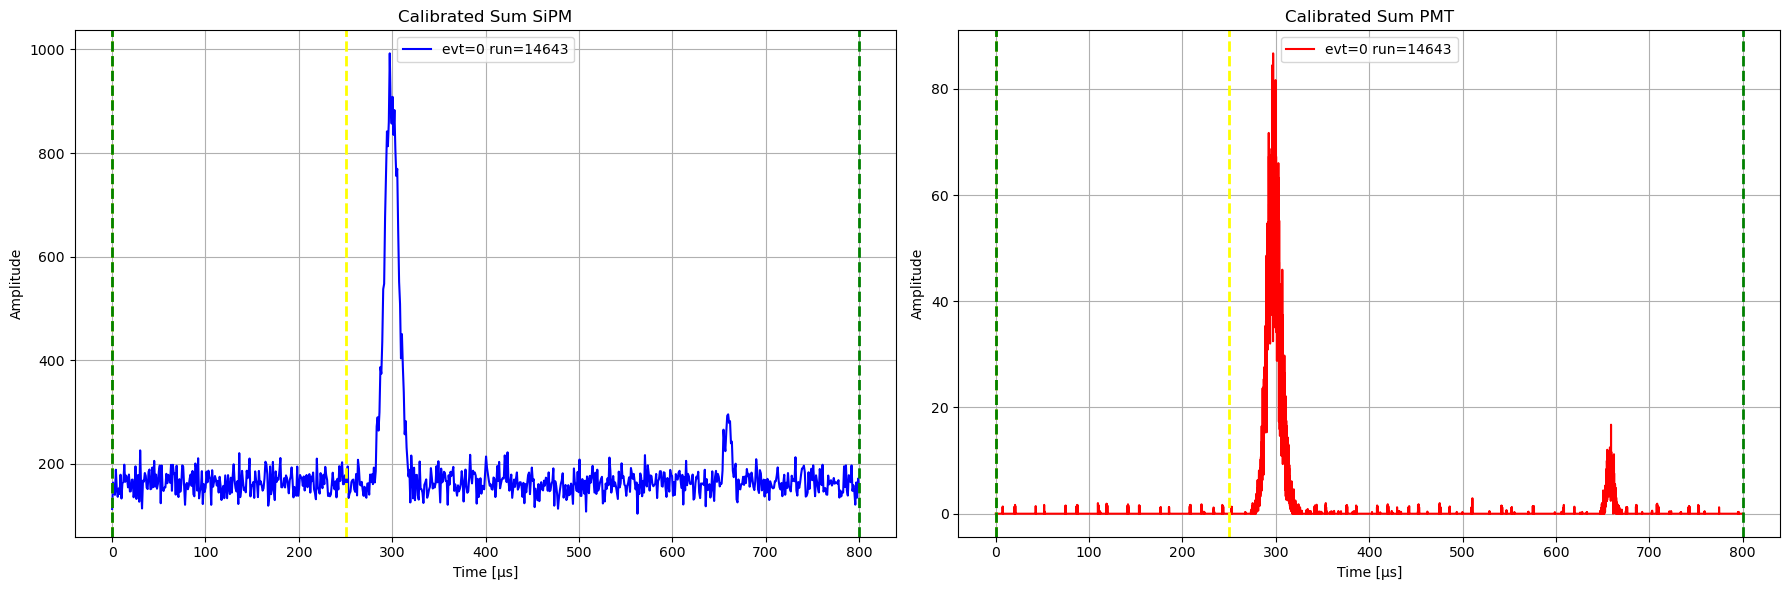

In [45]:
plot_sum_waveform(sipm_sum, cwf_sum_maw, sp.sipm_time_bins, sp.pmt_time_bins, run_number, event_number,
                  s1tmx = s1tmx/mus, s1tmn = s1tmn/mus,s2tmx = s2tmx/mus, s2tmn = s2tmn/mus,
                      figsize=(18, 6), tbin=25e-3)

## Find if there are glow spikes and suppress them

In [46]:
pp = find_peak_params(cwf_sum_maw, 0, len(cwf_sum_maw), prominence=1000, distance=20)

In [47]:
print_peak_pars(pp, tspmt)

found peaks -->[], time position (mus): []
prominences = []
widths (mus) = []
left ips (mus) = []
right ips (mus) = []
left cuts = [], right cuts = []


In [48]:
if len(pp.proms) > 0:
    plot_waveform(cwf_sum_maw, sp.pmt_time_bins, run_number, event_number, 
                  pp.peaks, pp.widths, pp.left_ips, pp.right_ips,
                  tbin=tspmt)

In [106]:
if len(pp.proms) > 0:
    plot_waveform_zoom_peaks(cwf_sum_maw, run_number, event_number, 
                         pp.peaks, pp.lcuts, pp.rcuts, twindows =pp.widths, 
                         tscale=True, figsize=(18, 6))

In [107]:
if len(pp.proms) > 0:
    sum_cwf_corr = suppress_glow(cwf_sum_maw, pp.peaks, pp.lcuts, pp.rcuts)
else:
    sum_cwf_corr = cwf_sum_maw

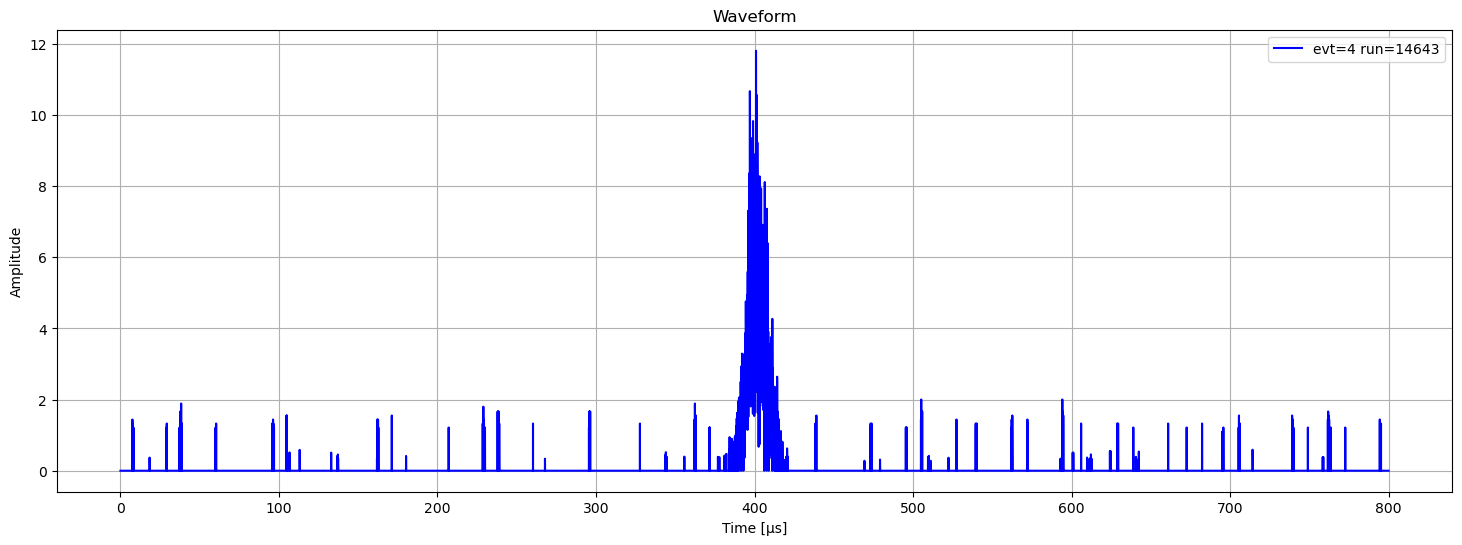

In [108]:
plot_waveform(sum_cwf_corr, sp.pmt_time_bins, run_number, event_number, figsize=(18, 6))

In [109]:
s2_rebin = int(ip.irene_pars["s2_rebin_stride"])
s2_rebin = 80
cwf_s2 = rebin_sum(sum_cwf_corr, s2_rebin)
t2_rebin = cwf_s2.shape[0]
tbins2=tspmt * s2_rebin
print(f"rebined s2 bins (mus) = {tbins2}")
print(f"cwf_2 lengths = {cwf_s2.shape[0]}")

rebined s2 bins (mus) = 2.0
cwf_2 lengths = 400


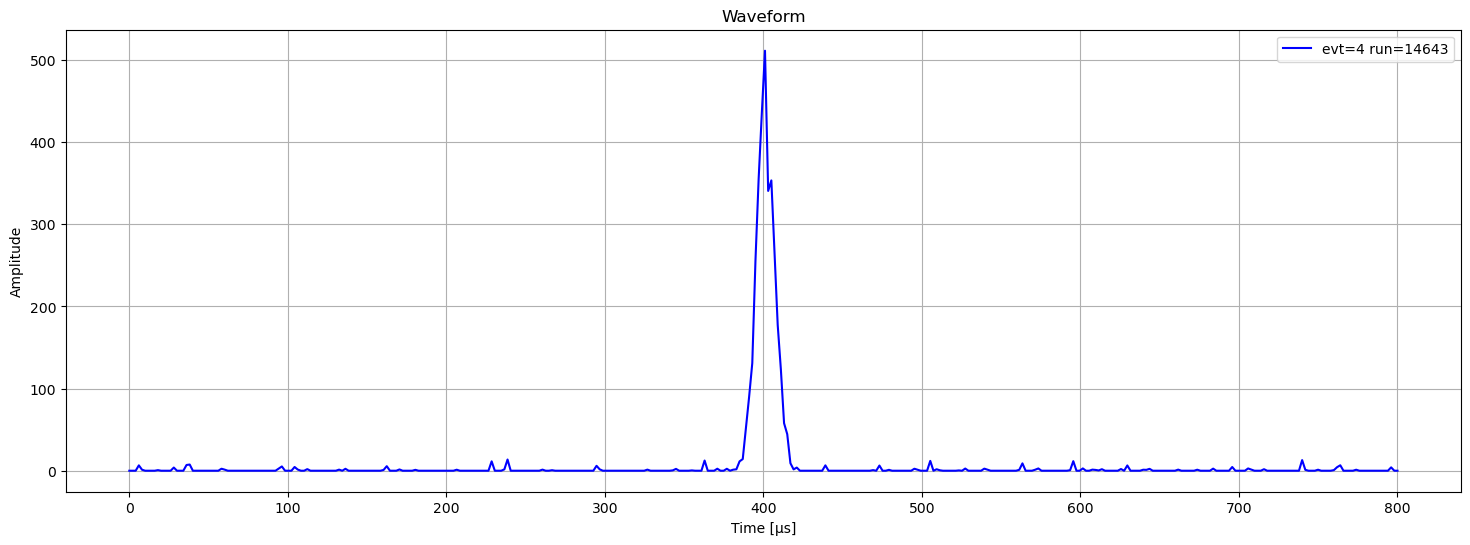

In [110]:
plot_waveform(cwf_s2, t2_rebin, run_number, event_number, figsize=(18, 6), tbin=tbins2)

In [111]:
ps2 = find_peak_params(cwf_s2, is2tmn, is2tmx, prominence=100, distance=10)

In [112]:
print_peak_pars(ps2, tbins2)

found peaks -->[200], time position (mus): [400.]
prominences = [511.39608304]
widths (mus) = [12.20063491]
left ips (mus) = [394.0038645]
right ips (mus) = [406.20449941]
left cuts = [184], right cuts = [215]


left cut = 381.80322959101375, right cut = 430.60576922728376


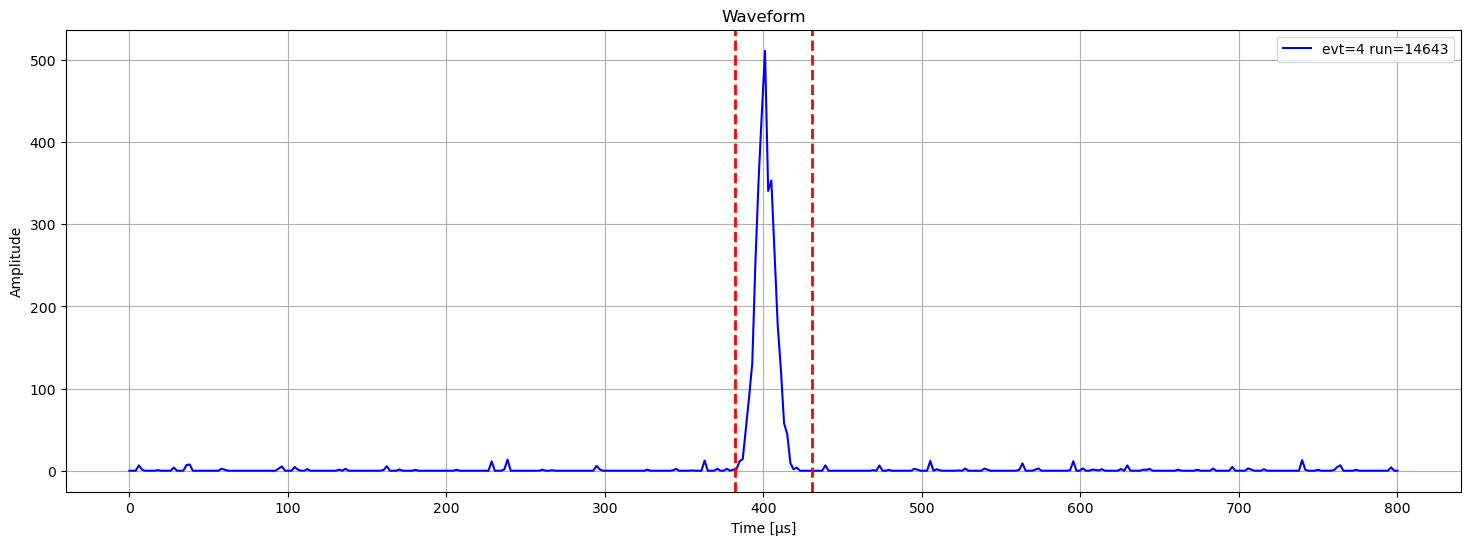

In [113]:
plot_waveform(cwf_s2, t2_rebin, run_number, event_number, 
              ps2.peaks, ps2.widths, ps2.left_ips, ps2.right_ips, tbin=tbins2, 
              figsize=(18, 6))

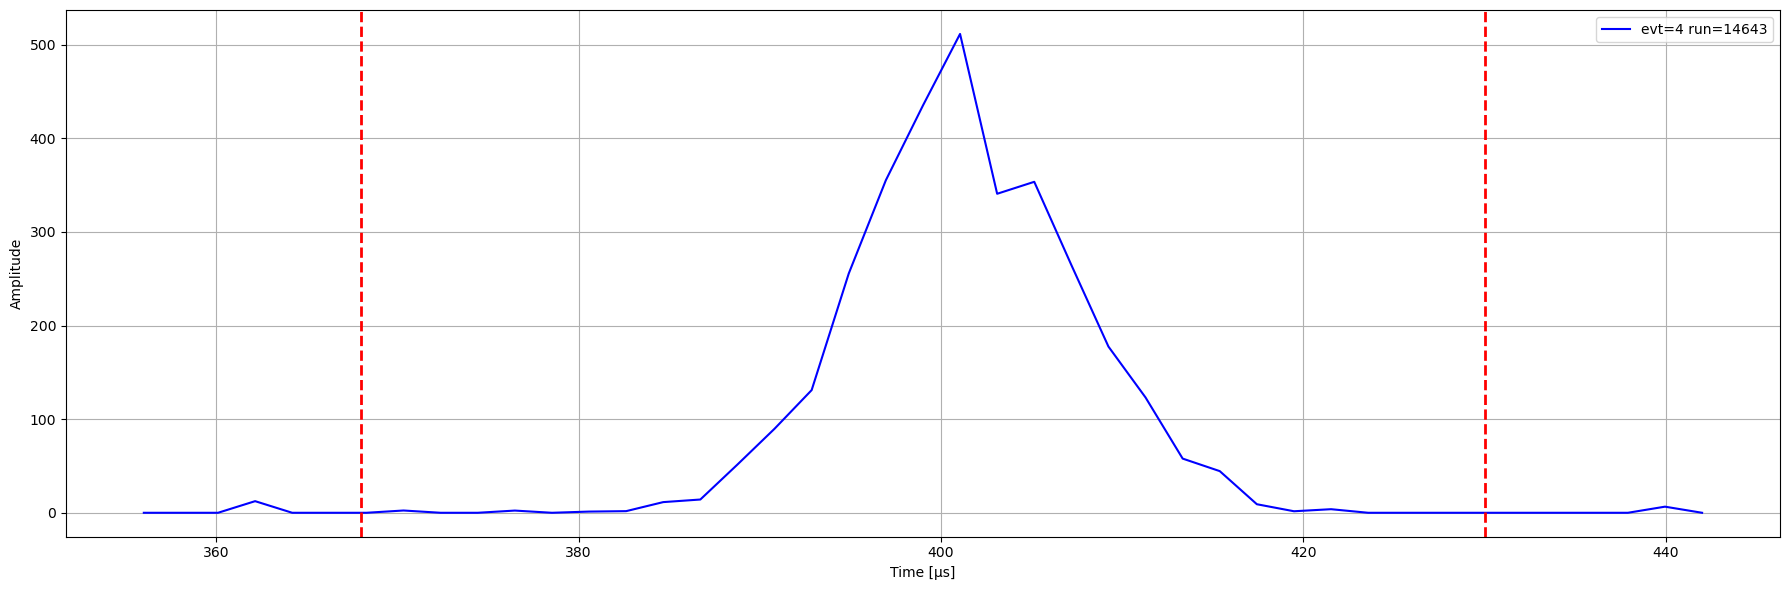

In [114]:
plot_waveform_zoom_peaks(cwf_s2, run_number, event_number, 
                         ps2.peaks, ps2.lcuts, ps2.rcuts,twindows =ps2.widths, 
                         tscale=True, tbin=tbins2, figsize=(18, 6))

In [115]:
print(f"Energy of S2 = {s12_energy(cwf_s2, ps2)} pes")

Energy of S2 = [3238.990287564604] pes


In [116]:
ps2

PeakPars(peaks=array([200]), widths=array([6.10031745]), proms=array([511.39608304]), left_ips=array([197.00193225]), right_ips=array([203.1022497]), lcuts=[184], rcuts=[215])

In [117]:
widths = [(ps2.rcuts[i] - ps2.lcuts[i])*tbins2 for i in range(len(ps2.rcuts))]
print(f"widths = {widths} mus")

widths = [62.0] mus


## S1 search

In [118]:
s1_rebin = int(ip.irene_pars["s1_rebin_stride"])
cwf_s1 = rebin_sum(sum_cwf_corr, s1_rebin)
t1_rebin = cwf_s1.shape[0]
tbinS1= tspmt * s1_rebin
print(f"s1 rebin = {s1_rebin}, t1 rebin = {t1_rebin}, tbin S1 = {tbinS1}")

s1 rebin = 1, t1 rebin = 32000, tbin S1 = 0.025


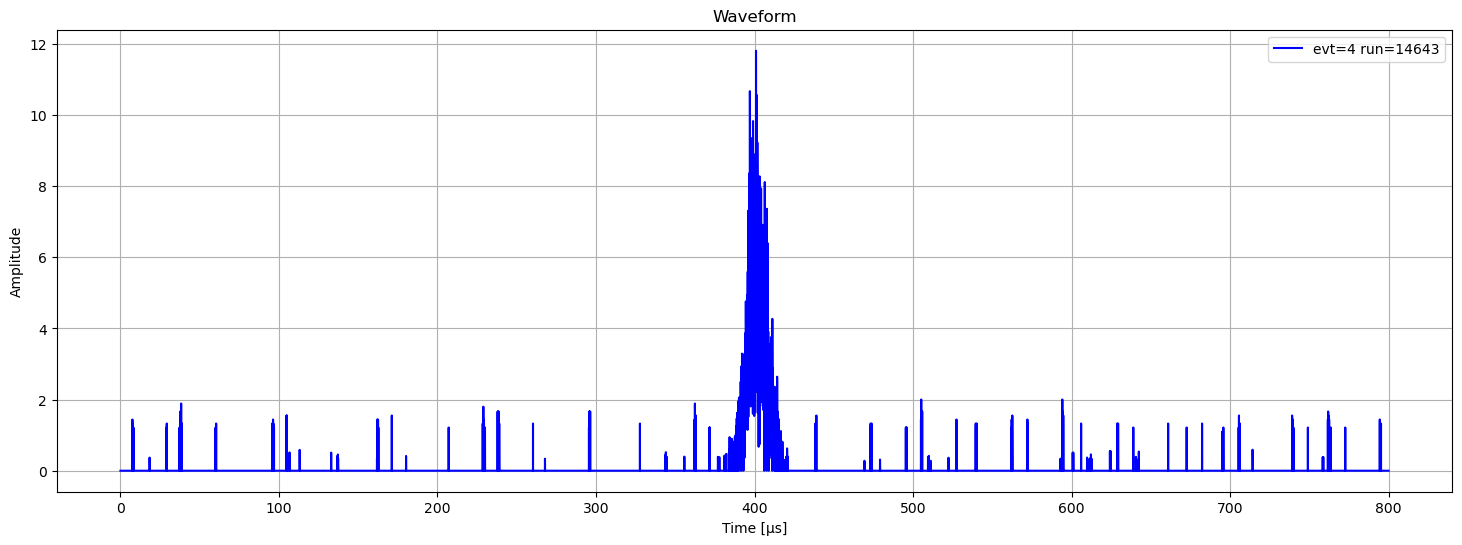

In [119]:
plot_waveform(cwf_s1, t1_rebin, run_number, event_number, figsize=(18, 6), tbin=tbinS1)

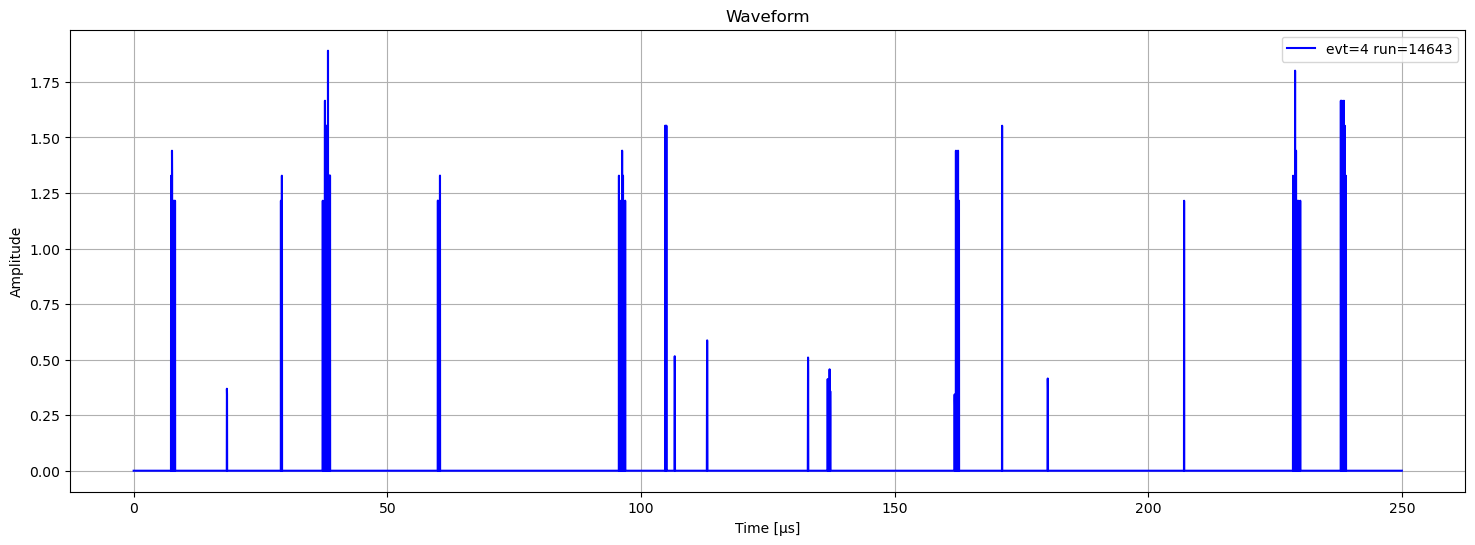

In [120]:
plot_waveform(cwf_s1[is1tmn:is1tmx], is1tmx-is1tmn, run_number, event_number, peaks=[], widths=[], left_ips=[], right_ips=[], 
                  figsize=(18, 6), tbin=25e-3)

In [121]:
ps1 = find_peak_params(cwf_s1, is1tmn, is1tmx,prominence=5, distance=10)

In [122]:
print_peak_pars(ps1, tspmt)

found peaks -->[], time position (mus): []
prominences = []
widths (mus) = []
left ips (mus) = []
right ips (mus) = []
left cuts = [], right cuts = []


In [123]:
if len(ps1.proms) > 0:
    plot_waveform(cwf_s1, t1_rebin, run_number, event_number, 
              ps1.peaks, ps1.widths, ps1.left_ips, ps1.right_ips,  
              tbin=tbinS1, figsize=(18, 6))

In [124]:
if len(ps1.proms) > 0:
    plot_waveform_zoom_peaks(cwf_s1, run_number, event_number, 
                         ps1.peaks, ps1.lcuts, ps1.rcuts,twindows =ps1.widths, 
                         tscale=True, tbin=tbinS1, figsize=(18, 6))

In [125]:
if len(ps1.proms) > 0:
    print(f"Energy of S1 = {s12_energy(cwf_s1, ps1)} pes")
    widths = [(ps1.rcuts[i] - ps1.lcuts[i])*tbinS1 for i in range(len(ps1.rcuts))]
    print(f"widths = {widths} mus")
else:
    print(f"S1 not found")

S1 not found


## SiPMs

#### Masked SiPMs

In [126]:
msipm = [2425]

In [127]:
sipmrbwf[msipm] = 0

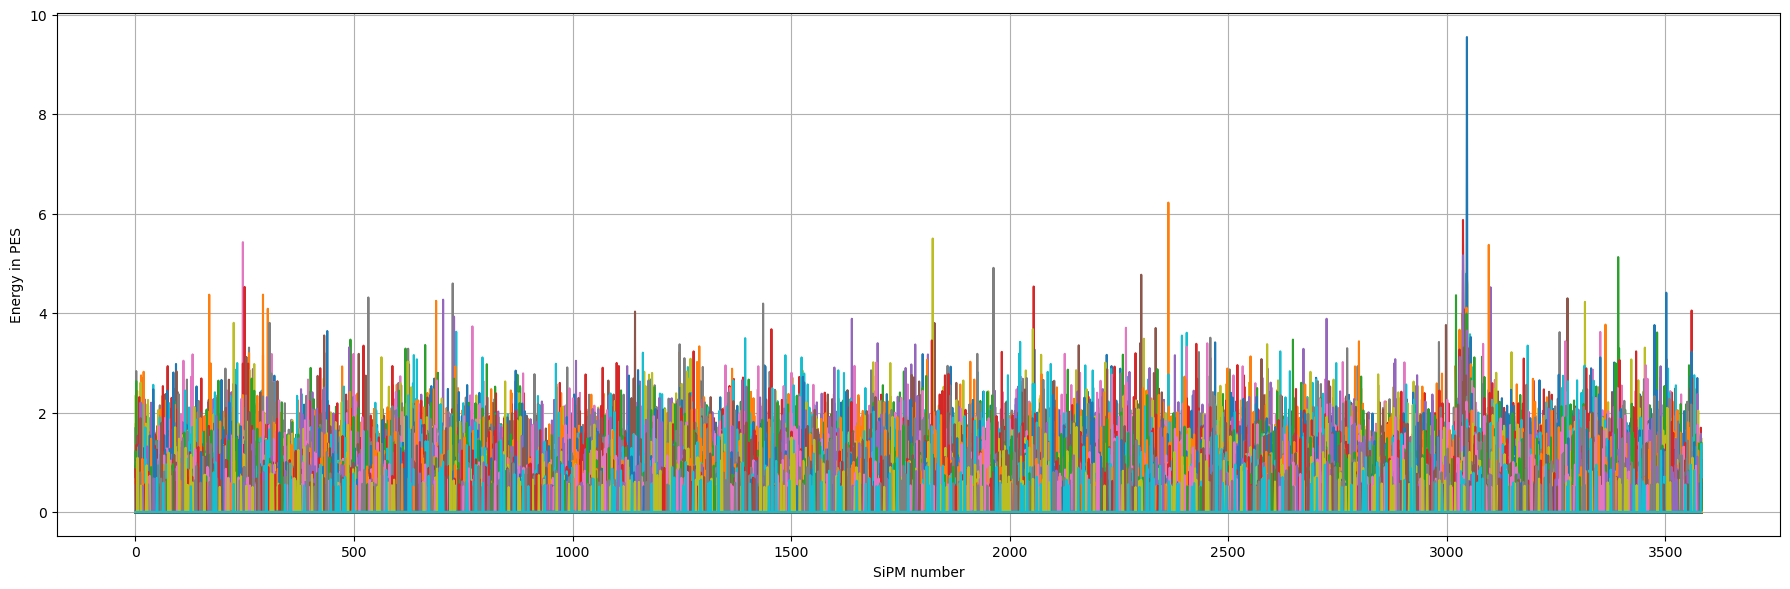

In [128]:
plot_sipmw([sipmrbwf])

In [129]:
SIPMW = get_s2_windows(sipmrbwf, ps2)

[184] [215]
peak number = 0
ipl = 184, ipr=215
sipm window shape (3584, 31)


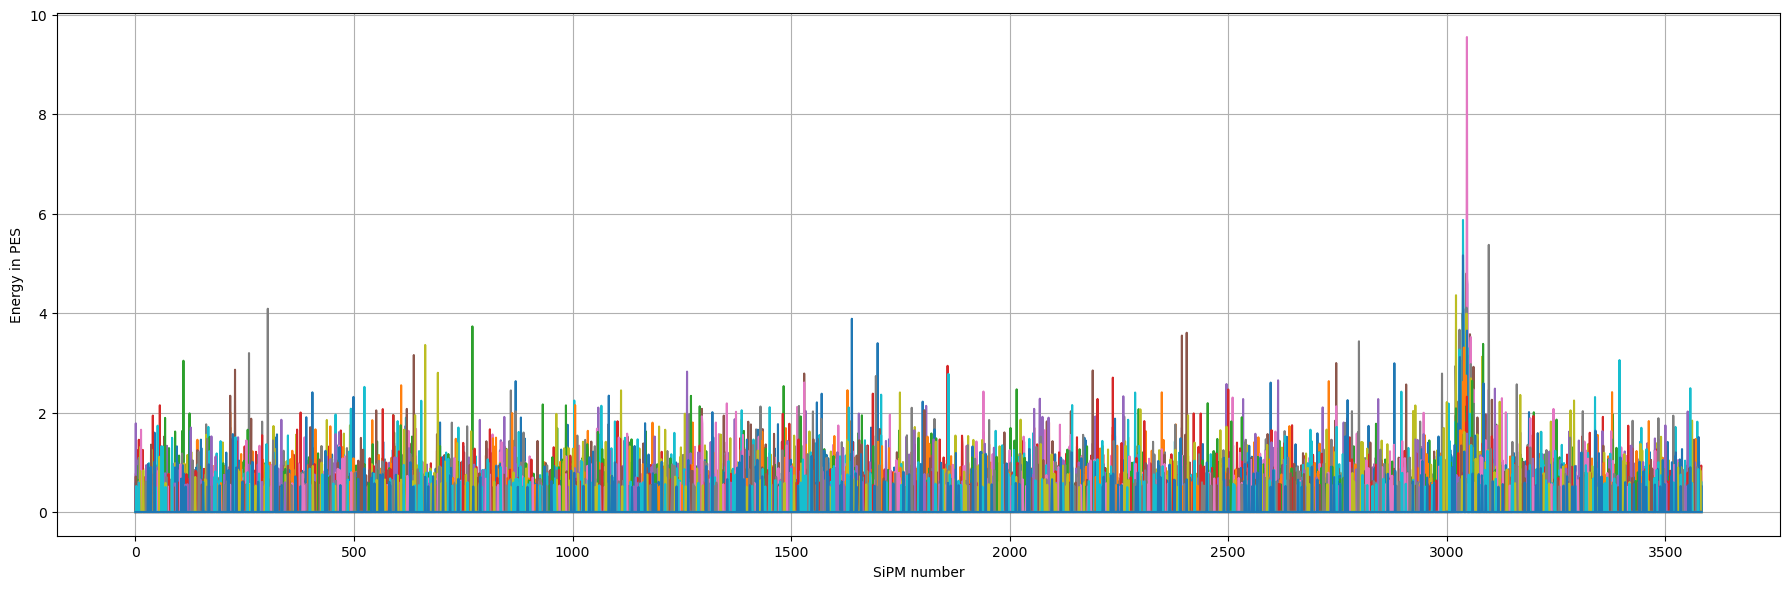

In [130]:
plot_sipmw(SIPMW)

In [137]:
QSIPM = s2_windows_sum(SIPMW, thr=5)

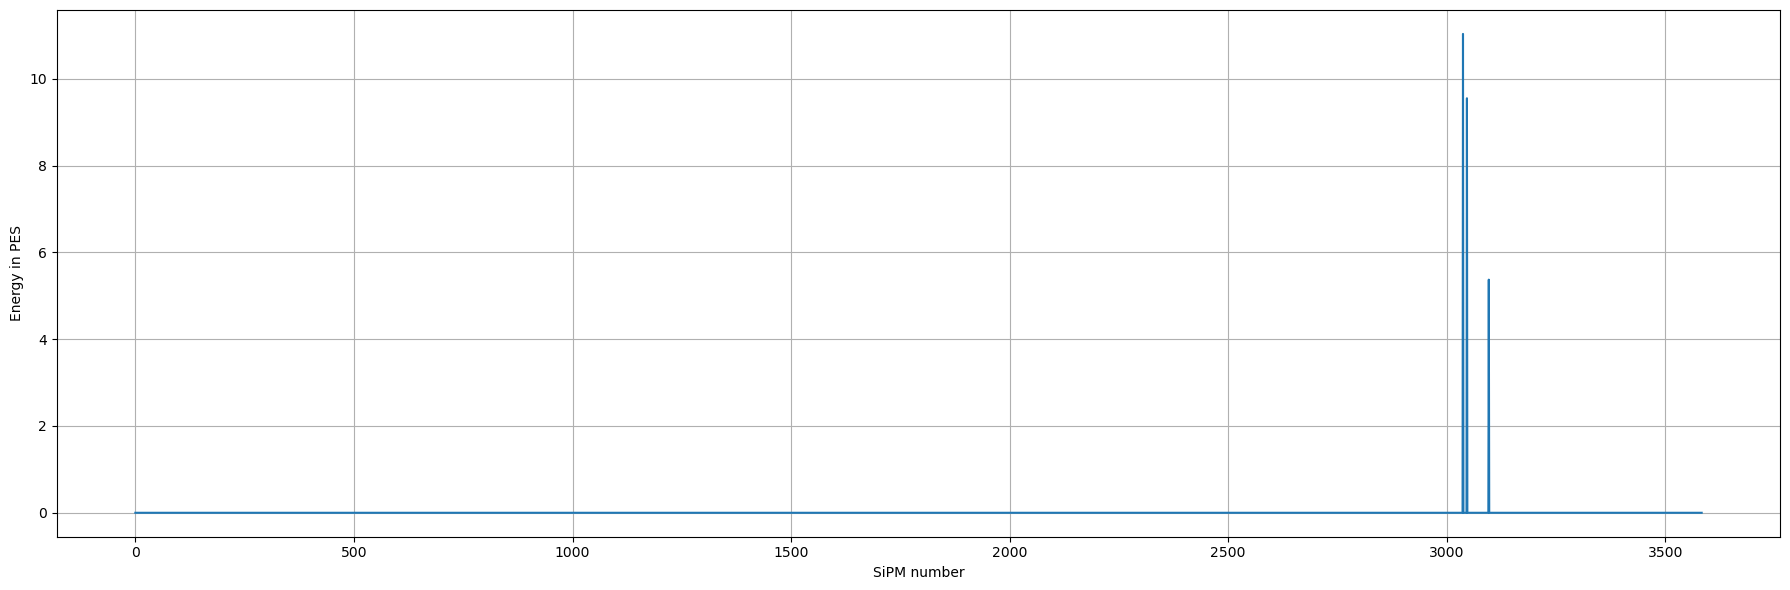

In [138]:
plot_sipmw(QSIPM)

In [139]:
XG, YG = sipm_xg(XSi, YSi, QSIPM)

xsi = 310.1470846046311, ysi = 44.89426850731029


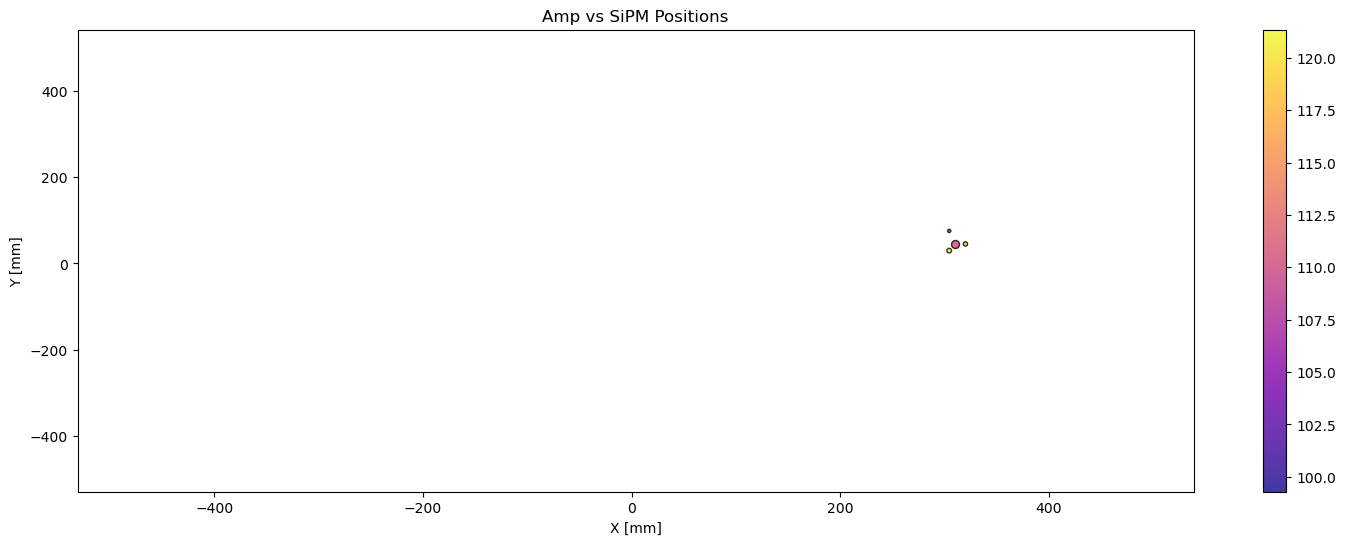

In [140]:
plot_sipm(XSi,YSi,QSIPM, XG, YG, figsize=(18, 6))